In [1]:
import joblib

# Load the model from the file
model = joblib.load('random_forest_3500_decision_tree.joblib')


In [2]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
import os
import numpy as np
import rasterio

def load_dataset(data_dir, img_size=(256, 256)):
    """
    Load validation and test datasets from specified directory.

    Parameters:
    - data_dir (str): Directory containing val and test subdirectories.
    - img_size (tuple): Desired size of the image (height, width).

    Returns:
    - val_data (tuple): Tuple containing (X_val, y_val).
    - test_data (tuple): Tuple containing (X_test, y_test).
    """
    val_dir = os.path.join(data_dir, 'val')
    test_dir = os.path.join(data_dir, 'test')

    # Load validation data
    X_val, y_val = load_data_from_dir(os.path.join(val_dir, 'input'), os.path.join(val_dir, 'output'), img_size)
    # Load test data
    X_test, y_test = load_data_from_dir(os.path.join(test_dir, 'input'), os.path.join(test_dir, 'output'), img_size)

    # Preprocess to handle NaN values
    X_val = preprocess_data(X_val)
    X_test = preprocess_data(X_test)

    return (X_val, y_val), (X_test, y_test)

def preprocess_data(images):
    """
    Preprocesses input images to handle NaN values.

    Parameters:
    - images (numpy.ndarray): Array of input images.

    Returns:
    - images (numpy.ndarray): Processed array of input images.
    """
    # Replace NaN values with 0
    images[np.isnan(images)] = 0

    return images

def load_data_from_dir(input_dir, output_dir, img_size):
    """
    Load data (images and labels) from input and output directories.

    Parameters:
    - input_dir (str): Directory containing input images.
    - output_dir (str): Directory containing output images.
    - img_size (tuple): Desired size of the image (height, width).

    Returns:
    - images (numpy.ndarray): Array of loaded input images.
    - labels (numpy.ndarray): Array of corresponding output images.
    """
    images = []
    labels = []

    for filename in os.listdir(input_dir):
        if filename.endswith('.tif'):
            # Load input image (X)
            input_path = os.path.join(input_dir, filename)
            img = load_tiff_image(input_path, img_size)
            images.append(img)

            # Load corresponding output image (y)
            output_filename = filename.replace('.tif', '_cl.tif')
            output_path = os.path.join(output_dir, output_filename)
            label = load_tiff_image(output_path, img_size, is_label=True)
            label[np.isnan(label)] = 0 
            labels.append(label)

    if images and labels:
        images = np.array(images)
        labels = np.array(labels)

    return images, labels

def load_tiff_image(path, img_size, is_label=False):
    """
    Load a TIFF image from specified path.

    Parameters:
    - path (str): Path to the TIFF image.
    - img_size (tuple): Desired size of the image (height, width).
    - is_label (bool): Whether the image is a label image.

    Returns:
    - img (numpy.ndarray): Loaded image as a numpy array.
    """
    with rasterio.open(path) as src:
        img = src.read()

    # Reshape and resize if necessary
    img = img.transpose(1, 2, 0)  # Change from bands x height x width to height x width x bands
    img = img[:img_size[0], :img_size[1], :]  # Resize to desired size

    if is_label:
        # Convert label image to binary classification (1 for Marine Debris, 0 for others)
        img = (img == 1).astype(np.uint8)  # Assuming Marine Debris class is encoded as 1

    return img

# Example usage:
data_dir = 'MARIDA'
(X_val, y_val), (X_test, y_test) = load_dataset(data_dir)

print(f"Validation data: X_val shape = {X_val.shape}, y_val shape = {y_val.shape}")
print(f"Testing data: X_test shape = {X_test.shape}, y_test shape = {y_test.shape}")


Validation data: X_val shape = (328, 256, 256, 11), y_val shape = (328, 256, 256, 1)
Testing data: X_test shape = (359, 256, 256, 11), y_test shape = (359, 256, 256, 1)


In [4]:
test_x = np.reshape(X_test,(359*256*256,11))

In [5]:
test_y = np.reshape(y_test,(359*256*256,1))
test_y.shape

(23527424, 1)

In [6]:
Coastal = pd.DataFrame(test_x).iloc[:, 0]  # costel 
Blue = pd.DataFrame(test_x).iloc[:, 1] # blue 
Green = pd.DataFrame(test_x).iloc[:, 2] # green 
RED = pd.DataFrame(test_x).iloc[:, 3] #
RedEdge1 = pd.DataFrame(test_x).iloc[:, 4]
RedEdge2 = pd.DataFrame(test_x).iloc[:, 5]
RedEdge3 = pd.DataFrame(test_x).iloc[:, 6]
NIR = pd.DataFrame(test_x).iloc[:, 7]
Narrow_NIR = pd.DataFrame(test_x).iloc[:, 8]
SWIR1 = pd.DataFrame(test_x).iloc[:, 9]
SWIR2 = pd.DataFrame(test_x).iloc[:, 10]

# print(first_column.tolist())

In [7]:
NDVI = (NIR - RED) / (NIR + RED)
print(np.isinf(NDVI).sum())
print(np.isinf(NDVI).sum())

0
0


In [8]:
Plastic = NIR / (NIR - RED)
print(np.isinf(Plastic).sum())
print(np.isinf(-Plastic).sum())

0
0


In [9]:
FDI = NIR - (RedEdge2+ (SWIR1 - RedEdge2) * ((842 - 665)/(1610 - 665)) * 10  )
np.isinf(FDI).sum()
np.isinf(-FDI).sum()

0

In [10]:
WaterIndex = (Green-NIR)/ (Green+NIR)
np.isinf(WaterIndex).sum()
np.isinf(-WaterIndex).sum()

0

In [11]:
X_test = pd.concat([FDI,WaterIndex,Plastic,NDVI,SWIR1,NIR,RED],axis=1)
X_test.shape

(23527424, 7)

In [12]:
np.isinf(X_test).sum()

0    0
1    0
2    0
3    0
9    0
7    0
3    0
dtype: int64

In [13]:
# Assuming X_test is a numpy array or pandas DataFrame
predictions = model.predict(X_test)

In [14]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Evaluate model performance
accuracy = accuracy_score(test_y, predictions)
# print(f'Accuracy: {accuracy:.2f}')

In [15]:
report = classification_report(predictions, test_y)
report

'              precision    recall  f1-score   support\n\n           0       0.99      1.00      1.00  23405068\n           1       0.91      0.00      0.01    122356\n\n    accuracy                           0.99  23527424\n   macro avg       0.95      0.50      0.50  23527424\nweighted avg       0.99      0.99      0.99  23527424\n'

In [16]:
# Calculate confusion matrix
cm = confusion_matrix(test_y, predictions)
cm

array([[23405032,   122011],
       [      36,      345]])

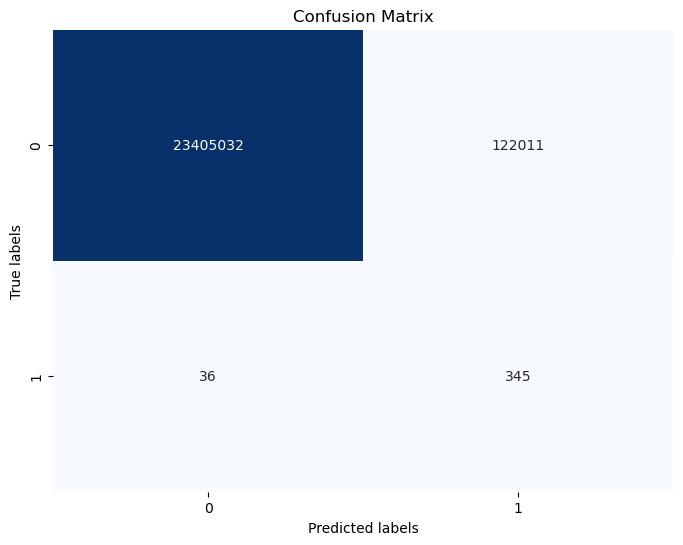

In [17]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('Confusion_matrix_Random_forest_100_Decision_tree.png')
plt.show()


In [18]:
# Compute precision, recall, and F1-score
precision = precision_score(test_y, predictions)
recall = recall_score(test_y, predictions)
f1 = f1_score(test_y, predictions)



In [19]:
print("Confusion Matrix:")
# print(cm)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Confusion Matrix:
Precision: 0.00
Recall: 0.91
F1-score: 0.01


In [20]:
TP = 148
FN = 484
FP= 233
# tn = 

In [21]:
iou_like = TP / (TP + FP + FN)

In [22]:
iou_like

0.17109826589595376

In [23]:
TP = 23526559
FN = 484
FP= 233

In [24]:
iou = TP / (TP + FP + FN)

In [25]:
iou


0.9999695247337601

In [26]:
X_val.shape


(328, 256, 256, 11)

In [27]:
# np.reshape(y_test,(359*256*256,1))
X = np.reshape(X_val,(328* 256* 256,11))
Y = np.reshape(y_val,(328* 256* 256,1))

In [28]:
X.shape

(21495808, 11)

In [29]:
Coastal = pd.DataFrame(X).iloc[:, 0]  # costel 
Blue = pd.DataFrame(X).iloc[:, 1] # blue 
Green = pd.DataFrame(X).iloc[:, 2] # green 
RED = pd.DataFrame(X).iloc[:, 3] #
RedEdge1 = pd.DataFrame(X).iloc[:, 4]
RedEdge2 = pd.DataFrame(X).iloc[:, 5]
RedEdge3 = pd.DataFrame(X).iloc[:, 6]
NIR = pd.DataFrame(X).iloc[:, 7]
Narrow_NIR = pd.DataFrame(X).iloc[:, 8]
SWIR1 = pd.DataFrame(X).iloc[:, 9]
SWIR2 = pd.DataFrame(X).iloc[:, 10]

# print(first_column.tolist())

In [30]:
NDVI = (NIR - RED) / (NIR + RED)
print(np.isinf(NDVI).sum())
print(np.isinf(NDVI).sum())

0
0


In [31]:
Plastic = NIR / (NIR - RED)
print(np.isinf(Plastic).sum())
print(np.isinf(-Plastic).sum())

0
0


In [32]:
FDI = NIR - (RedEdge2+ (SWIR1 - RedEdge2) * ((842 - 665)/(1610 - 665)) * 10  )
np.isinf(FDI).sum()
np.isinf(-FDI).sum()

0

In [33]:
WaterIndex = (Green-NIR)/ (Green+NIR)
np.isinf(WaterIndex).sum()
np.isinf(-WaterIndex).sum()

0

In [34]:
X_val = pd.concat([FDI,WaterIndex,Plastic,NDVI,SWIR1,NIR,RED],axis=1)
X_val.shape

(21495808, 7)

In [35]:
# Assuming X_test is a numpy array or pandas DataFrame
predictions = model.predict(X_val)


In [36]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

# Evaluate model performance
accuracy = accuracy_score(Y, predictions)
# print(f'Accuracy: {accuracy:.2f}')

In [37]:
# Calculate confusion matrix
cm = confusion_matrix(Y, predictions)
cm

array([[21421152,    73581],
       [      84,      991]])

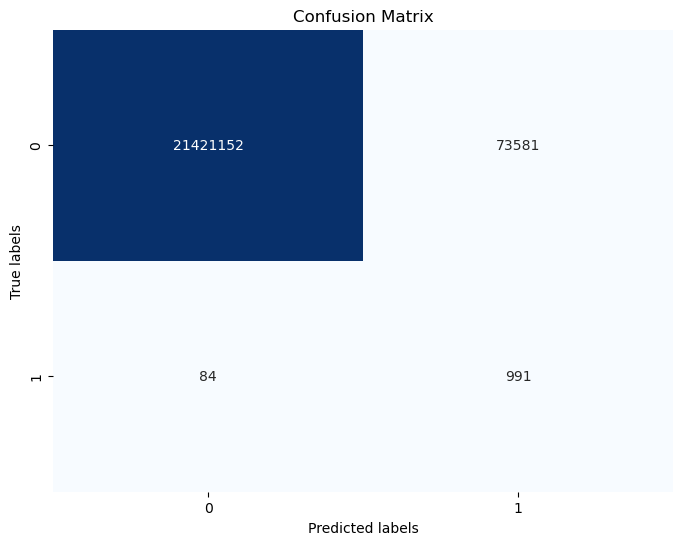

In [38]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('Confusion_matrix_Random_forest_100_Decision_tree.png')
plt.show()


In [39]:
# TP = 481
# FN = 594
# FP= 725

In [40]:
TP / (TP + FP + FN)

0.9999695247337601